In [1]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes
from enum import Enum
import argparse
import os
import json

import seaborn as sns

from paper import *

PLAIN_COLOR = "#4285F4"
INCREMENTAL_COLOR = '#DB4437'
COMMIT_COLOR = "#F4B400"
from enum import IntFlag

class Mode(IntFlag):
    OUT_OF_ORDER = 0
    IN_ORDER = 1
    COMMIT = 2
    INCREMENTAL = 4

In [2]:

palette_colors = [[.22, .52, .71], [.53, .80, .81],
                  [144 / 255., 12 / 255, 63 / 255.],
                  [67 / 255., 135 / 255., 107 / 255.],
                  [248 / 255., 194 / 255., 145 / 255.]]
sns.set_palette(palette_colors)

matplotlib.rc('font', family='serif', size=9)
matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=8)
matplotlib.rc('figure', figsize=(2.5, 1.4))
matplotlib.rc('axes', linewidth=0.5)
matplotlib.rc('lines', linewidth=0.5)

adjust_settings()

<ipython-input-2-98e1559fe72f>:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
/Users/leonhards/projects/tuplex-public/benchmarks/incremental/notebooks/paper.py:36: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])


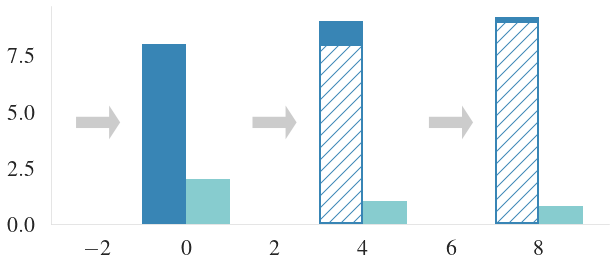

In [89]:
# generate from these the plot
e_pct = np.array([.2, .1, .08])

# calc normal from e_pct
n_pct = [0] * len(e_pct)
n_pct[0] = 1.0 - e_pct[0]
n_last_pct = [0] * len(n_pct)

for i in range(1, len(e_pct)):
    n_pct[i] = n_pct[i-1] + e_pct[i-1] - e_pct[i]
    n_last_pct[i] = n_pct[i - 1]
e_pct, n_pct

xq = list(range(2 * len(n_pct)))
for i in range(0, len(xq), 2):
    xq[i] *= 2
    xq[i + 1] = xq[i] + 1
xq

plt.figure(figsize=(10,4))
lw= 2
plt.bar(np.array(xq[::2])-.5, (np.array(n_pct) - np.array(n_last_pct)) * 10, 
        bottom = np.array(n_last_pct) * 10,
        width=1, ec='none', linewidth=lw)
patches = plt.bar(np.array(xq[::2])-.5, np.array(n_last_pct) * 10, width=1, color='none',
        ec=sns.color_palette()[0], hatch='//', linewidth=2 * lw)


plt.bar(np.array(xq[1::2]) -.5, np.array(e_pct) * 10, width=1, color=sns.color_palette()[1],
        ec='none', linewidth=lw)
# plt.bar(np.array(xq[::2])-.5, np.array(n_last_pct) * 10, width=1)

for bar in patches:
    bar.set_clip_path(bar.get_path(), bar.get_transform())

# xq = [0, 1, 4, 5]
# yq = [10, 4, 12, 3]
# plt.bar(xq, yq)

# #plt.text(5.25, 0.05, savings_label, ha="center", va="center", size=20, bbox=dict(facecolor='white', alpha=1.0))
for i in range(len(n_pct)):
    plt.arrow(1.5 + 4 * i - 4, 4.5, 1, 0, length_includes_head=True, width=0.5,
              head_width=1.5, head_length=.25, edgecolor='none', facecolor=[0.8]*3)
# plt.axis('off')
plt.grid(False)
sns.despine()

In [172]:
# cost curves (cumulative, r5d.8xlarge)

# TODO plot this => how much does a second cost?

# $2.304 on-demand, r5d.8xlarge cost per hour
cost_per_h = 2.304
cost_per_s = cost_per_h / 3600.0

cost_per_s

0.0006399999999999999

In [200]:
gdf = df.groupby(['run', 'order', 'incremental', 'commit'])
df_cum = pd.DataFrame()
for k in gdf.groups.keys():
    subdf = gdf.get_group(k).sort_values(by='step').reset_index(drop=True)
    subdf['jobTimeCumulative'] = subdf['jobTime'].cumsum()
    subdf['fast_path_time_s_cumulative'] = subdf['fast_path_time_s'].cumsum()
    subdf['slow_path_time_s_cumulative'] = subdf['slow_path_time_s'].cumsum()
    subdf['write_output_wall_time_s_cumulative'] = subdf['write_output_wall_time_s'].cumsum()
    df_cum = pd.concat((df_cum, subdf))

In [204]:
df_cum_mu = df_cum.groupby(['step', 'order', 'incremental', 'commit']).mean().reset_index()
df_cum_std = df_cum.groupby(['step', 'order', 'incremental', 'commit']).std().reset_index()

In [256]:
# cost reduction
subdf = df_cum_mu[(df_cum_mu['step'] == 6) & ~df_cum_mu['commit']].groupby(['order', 'commit'])['jobTimeCumulative'].agg(['min', 'max']).reset_index()
subdf['reduction'] = 1.0 - subdf['min'] / subdf['max']
a_min = subdf['reduction'].min() 
a_max = subdf['reduction'].max()

savings_label = '${:.0f}\\mathrm{{\\%}} - {:.0f}\\mathrm{{\\%}}$'.format(a_min * 100, a_max * 100)
savings_label

'$63\\mathrm{\\%} - 67\\mathrm{\\%}$'

In [257]:
def sel_df(df, order, incremental):
    return df[(df['order'] == order) & (df['incremental'] == incremental) & ~df['commit']].sort_values(by='step').reset_index(drop=True)

In [258]:
combos = [('in', False), ('in', True), ('out', False), ('out', True)]

<ipython-input-328-b59f7c08f5b2>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.arrow(6, 0.075, 0, -0.041, length_includes_head=True, width=0.1,


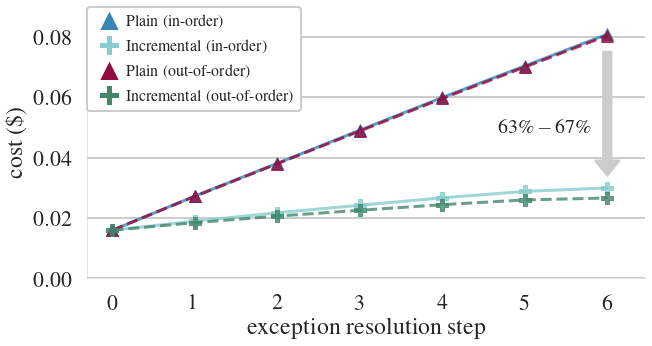

In [328]:
plt.figure(figsize=(10, 5))
markers = ['^', 'P', '^', 'P']
linestyles=['-', '-', '--', '--']
for i, combo in enumerate(combos):
    order, inc = combo
    marker = markers[i]
    ls = linestyles[i]
    subdf_mu = sel_df(df_cum_mu, order, inc)
    subdf_std = sel_df(df_cum_std, order, inc)
    plt.plot(subdf_mu['step'], subdf_mu['jobTimeCumulative'] * cost_per_s,
             marker=marker, linewidth=3, alpha=.8, linestyle=ls)

plt.text(5.25, 0.05, savings_label, ha="center", va="center", size=20, bbox=dict(facecolor='white', alpha=1.0))
plt.arrow(6, 0.075, 0, -0.041, length_includes_head=True, width=0.1,
          head_width=0.3, head_length=0.005, edgecolor='none', color=[0.8]*3)

hlabels=[('Plain (in-order)', sns.color_palette()[0]),
         ('Incremental (in-order)', sns.color_palette()[1]),
         ('Plain (out-of-order)', sns.color_palette()[2]),
         ('Incremental (out-of-order)', sns.color_palette()[3])]
handles = []
for i, h in enumerate(hlabels):
    marker = markers[i]
    handles.append(Line2D([0], [0], marker=marker, color='w', label=h[0],
                        markerfacecolor=h[1], markersize=20))
plt.legend(handles=handles, fontsize=16, handletextpad=0.05, framealpha=1,
          bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0)

plt.ylim(0, 0.09)
plt.grid(axis='x')
sns.despine()
plt.ylabel('cost (\$)')
plt.xlabel('exception resolution step')

plt.savefig(os.path.join('plots', 'cost-curve.pdf'), transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)